### Notebook for Data transformation, preparation and model development for hourly air quality forecasting

In [2]:
#pip install scikit-optimize

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math

from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from keras.models import Sequential

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras.layers import Activation

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#from keras.optimizers import RMSprop
from keras.regularizers import l1, l2

#from skopt import Optimizer
#from skopt import BayesSearchCV 
#from skopt.space import Real, Categorical, Integer

import tensorflow as tf
from tensorflow import keras

from datetime import datetime

import random

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
df=pd.read_csv('Hourly_Preprocessed_Dataset.csv',index_col=0)
df.head()

,CO,NO2,OZONE,PM10,PM25,SO2,Barometric_Pressure,Dewpoint,Relative_Humidity,Temperature,Wind_Speed,season,weekend_flag,peak_hours
2015-01-02 10:00:00,-0.482597,-0.599879,-0.182026,-0.063857,-0.093282,0.005219,1.331716,-0.390781,-0.359205,-1.371250,0.224861,3,1,0
2015-01-02 11:00:00,-0.496857,-0.717961,0.095772,-0.155189,-0.093282,-0.124040,1.143620,-0.524329,-0.536764,-1.154079,-0.152468,3,1,0
2015-01-02 12:00:00,-0.513493,-0.763377,0.289706,-0.312401,0.166494,-0.253299,0.977468,-1.337763,-0.762775,-0.895541,-0.392585,3,1,0
2015-01-02 13:00:00,-0.454077,-0.708877,0.289706,-0.358815,-0.014666,-0.382557,0.914769,-1.532016,-0.777822,-0.802467,-0.907124,3,1,0
2015-01-02 14:00:00,-0.437441,-0.708877,0.394536,-0.351329,0.039597,-0.382557,0.852070,-1.871958,-0.782035,-0.750760,-0.598401,3,1,0


In [4]:
df.index= pd.to_datetime(df.index)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52574 entries, 2015-01-02 10:00:00 to 2020-12-31 23:00:00
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CO                   52574 non-null  float64
 1   NO2                  52574 non-null  float64
 2   OZONE                52574 non-null  float64
 3   PM10                 52574 non-null  float64
 4   PM25                 52574 non-null  float64
 5   SO2                  52574 non-null  float64
 6   Barometric_Pressure  52574 non-null  float64
 7   Dewpoint             52574 non-null  float64
 8   Relative_Humidity    52574 non-null  float64
 9   Temperature          52574 non-null  float64
 10  Wind_Speed           52574 non-null  float64
 11  season               52574 non-null  int64  
 12  weekend_flag         52574 non-null  int64  
 13  peak_hours           52574 non-null  int64  
dtypes: float64(11), int64(3)
memory usage: 6.0 MB


In [6]:
df.index.dtype

dtype('<M8[ns]')

In [7]:
#make sure dataset is sorted on date and hour
df.sort_index(inplace=True)

In [8]:
# load the scaler

scaler=pickle.load(open('scaler.pkl', 'rb'))

In [9]:
#next add lag features by converting time series to supervised.
#function to ad lead and lag features.
# convert series to supervised learning
#Reference : https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
# split data into train ,validation and test sets
def split_data(data,reshape='no',n_hours = 1, n_features = 10):
    values = data.values
    #use data for 2015-2017 for training, 2018-2019 for validation and 2020 for testing
    #train = values[:26304, :]
    train = values[:26265, :]
    #valid = values[26304:43824, :]
    valid = values[26265:43785, :]
    #test = values[43824:, :]
    test = values[43785:, :]
    # split into input and outputs
    n_obs = n_hours * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    valid_X,valid_y = valid[:, :n_obs], valid[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    if reshape=='yes':
        train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
        valid_X = valid_X.reshape((valid_X.shape[0], n_hours, n_features))
        test_X  = test_X.reshape((test_X.shape[0], n_hours, n_features))
    return train_X, train_y, valid_X, valid_y, test_X, test_y

In [11]:
#Try this
def split_ml(data,n_hours = 1, n_features = 10):
    values = data.values
    #use data for 2015-2017 for training, 2018-2019 for validation and 2020 for testing

    train = values[:43785, :]

    test = values[43785:, :]
    # split into input and outputs
    n_obs = n_hours * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]

    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    
    return train_X, train_y, test_X, test_y

In [12]:
#Basic structure for LSTM model
def lstm_model(train_data):
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_data.shape[1], train_data.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [13]:
##Giving error - error when time step is 1
def CNN_model(train_data):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(train_data.shape[1], train_data.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [14]:
#Reference https://www.nature.com/articles/s41598-020-60102-6#Sec2
def DBN(train_data,g):
    fdp=0.19+0.0025 * g
    model = Sequential()
    model.add(Conv1D(filters=24, kernel_size=5, activation='relu', input_shape=(train_data.shape[1], train_data.shape[2])))
    #model.add(MaxPooling1D(pool_size=4))
    model.add(Dropout(0.2))
    model.add(LSTM(24))
    model.add(Dropout(fdp))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model   

In [15]:
#function to calculate different error metrics for models
#references https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/
def model_evaluation(y_actual,y_predicted):
    #rmse
    rmse = math.sqrt(mean_squared_error(y_actual, y_predicted))
    #mae
    mae=mean_absolute_error(y_actual, y_predicted)
    #mape
    mape = mean_absolute_error(y_actual, y_predicted)*100
    #r2
    r2=r2_score(y_actual, y_predicted)
    return rmse, mae, mape,r2

## CO Forecasting

In [16]:
#df_CO=df.iloc[:,[0,1,2,3,5,6,7,8,9,10,11]] #check with these , best DFN model
df_CO=df.iloc[:,[0,1,2,3,5,6,8,9,10]] #check with these , better 
#df_CO=df.iloc[:,[0,1,2,3,5,6,7,8,9,10]] #check with these , 

df_CO.head()

,CO,NO2,OZONE,PM10,SO2,Barometric_Pressure,Relative_Humidity,Temperature,Wind_Speed
2015-01-02 10:00:00,-0.482597,-0.599879,-0.182026,-0.063857,0.005219,1.331716,-0.359205,-1.371250,0.224861
2015-01-02 11:00:00,-0.496857,-0.717961,0.095772,-0.155189,-0.124040,1.143620,-0.536764,-1.154079,-0.152468
2015-01-02 12:00:00,-0.513493,-0.763377,0.289706,-0.312401,-0.253299,0.977468,-0.762775,-0.895541,-0.392585
2015-01-02 13:00:00,-0.454077,-0.708877,0.289706,-0.358815,-0.382557,0.914769,-0.777822,-0.802467,-0.907124
2015-01-02 14:00:00,-0.437441,-0.708877,0.394536,-0.351329,-0.382557,0.852070,-0.782035,-0.750760,-0.598401


In [17]:
# specify the number of lag hours
n_hours = 5
n_features = 9 #number of features in dataframe to be used

# frame as supervised learning with previous 5 hours data to predict upcoming hour data.
scaled_CO=df_CO.values
reframed_CO = series_to_supervised(scaled_CO, n_hours, 1)
print(reframed_CO.shape)

(52569, 54)


In [18]:
reframed_CO

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var1(t-4),...,var9(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t)
5,-0.482597,-0.599879,-0.182026,-0.063857,0.005219,1.331716,-0.359205,-1.371250,0.224861,-0.496857,...,-0.598401,-0.385154,-0.581713,0.425984,-0.492071,-0.382557,0.852070,-0.709507,-0.781784,-0.872821
6,-0.496857,-0.717961,0.095772,-0.155189,-0.124040,1.143620,-0.536764,-1.154079,-0.152468,-0.513493,...,-0.872821,-0.195022,-0.082136,-0.061472,-0.316892,-0.382557,0.809749,-0.347769,-1.019639,-0.907124
7,-0.513493,-0.763377,0.289706,-0.312401,-0.253299,0.977468,-0.762775,-0.895541,-0.392585,-0.454077,...,-0.907124,0.743755,1.334843,-1.167422,-0.285450,0.134478,0.892825,-0.046822,-1.329884,-0.667006
8,-0.454077,-0.708877,0.289706,-0.358815,-0.382557,0.914769,-0.777822,-0.802467,-0.907124,-0.437441,...,-0.667006,4.113848,2.143248,-1.576257,-0.180642,1.168549,0.955523,0.101846,-1.453982,-0.769914
9,-0.437441,-0.708877,0.394536,-0.351329,-0.382557,0.852070,-0.782035,-0.750760,-0.598401,-0.385154,...,-0.769914,5.748984,2.061500,-1.576257,0.066404,1.556325,1.040167,0.199051,-1.557397,-0.667006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52569,-0.252062,-0.227468,0.153428,-0.132730,-0.253299,1.665587,-0.785045,-0.678369,0.636491,-0.306725,...,-0.015257,-0.071436,0.263025,-0.716656,-0.075835,-0.253299,1.665587,-0.351681,-1.298860,-0.598401
52570,-0.306725,-0.345549,0.111496,-0.146206,-0.124040,1.665587,-0.977651,-0.719735,0.670794,-0.202152,...,-0.598401,0.301698,0.671770,-1.078317,0.276020,0.263737,1.665587,-0.110924,-1.236811,-0.461191
52571,-0.202152,-0.036720,-0.092921,-0.222565,-0.253299,1.665587,-0.881348,-0.885199,-0.186770,-0.033410,...,-0.461191,-0.035786,-0.136636,-0.501756,-0.186631,-0.253299,1.665587,0.274288,-1.505690,0.087650
52572,-0.033410,0.417440,-0.444099,0.094852,-0.124040,1.665587,-0.640590,-1.040322,-0.083862,-0.242555,...,0.087650,-0.059553,-0.254717,-0.360236,-0.333362,-0.382557,1.665587,0.322440,-1.598763,-0.118165


In [19]:
#CO:
CO_train_X, CO_train_y, CO_valid_X, CO_valid_y, CO_test_X, CO_test_y=split_data(reframed_CO,reshape='yes',n_hours=n_hours,n_features=n_features) #for lstm 3d data is required
print("training data CO:",CO_train_X.shape, len(CO_train_X), CO_train_y.shape,)
print("validation data CO:",CO_valid_X.shape, len(CO_valid_X), CO_valid_y.shape)
print("testing data CO:",CO_test_X.shape, len(CO_test_X), CO_test_y.shape)

training data CO: (26265, 5, 9) 26265 (26265,)
validation data CO: (17520, 5, 9) 17520 (17520,)
testing data CO: (8784, 5, 9) 8784 (8784,)


In [20]:
(CO_train_X[0])

array([[-0.48259689, -0.59987891, -0.18202598, -0.06385671,  0.0052191 ,
         1.33171602, -0.35920499, -1.37125024,  0.22486052],
       [-0.4968568 , -0.71796055,  0.09577187, -0.15518908, -0.12403976,
         1.14361968, -0.53676363, -1.15407855, -0.15246756],
       [-0.51349337, -0.76337657,  0.28970621, -0.31240055, -0.25329862,
         0.97746792, -0.76277471, -0.89554081, -0.39258543],
       [-0.45407707, -0.70887735,  0.28970621, -0.35881536, -0.38255747,
         0.91476914, -0.77782206, -0.80246723, -0.90712371],
       [-0.43744051, -0.70887735,  0.39453559, -0.3513291 , -0.38255747,
         0.85207036, -0.78203531, -0.75075968, -0.59840074]])

### CO -LSTM

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(patience=20)

#Random code
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

#model_CO=lstm_model(CO_train_X) #try different units in LSTM, getting better results with this one.

model_CO = Sequential()
model_CO.add(LSTM(50, activity_regularizer=l1(0.001), input_shape=(CO_train_X.shape[1], CO_train_X.shape[2])))
model_CO.add(Dropout(0.5)) 
model_CO.add(Dense(1))
model_CO.compile(loss='mse', optimizer='adam')
model_CO.summary()

# fit network
history = model_CO.fit(CO_train_X, CO_train_y, epochs=100, batch_size=72, validation_data=(CO_valid_X, CO_valid_y), verbose=2, shuffle=False,callbacks=[early_stopping, ModelCheckpoint(filepath='best_model_CO.h5', monitor='val_loss', save_best_only=True)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                12000     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 12,051
Trainable params: 12,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
365/365 - 5s - loss: 0.6435 - val_loss: 0.2558 - 5s/epoch - 13ms/step
Epoch 2/100
365/365 - 2s - loss: 0.3475 - val_loss: 0.2107 - 2s/epoch - 5ms/step
Epoch 3/100
365/365 - 2s - loss: 0.3057 - val_loss: 0.1865 - 2s/epoch - 5ms/step
Epoch 4/100
365/365 - 2s - loss: 0.2896 - val_loss: 0.1847 - 2s/epoch - 

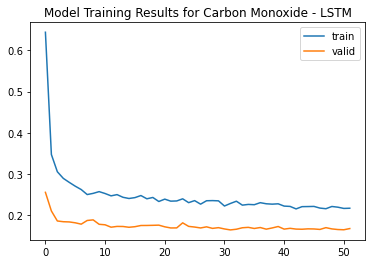

In [22]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.title('Model Training Results for Carbon Monoxide - LSTM')
plt.show()

In [23]:
model_CO.evaluate(CO_test_X,CO_test_y)

275/275 [==============================] - 0s 2ms/step - loss: 0.1336


0.1335725635290146

In [24]:
from keras.models import load_model
model_CO = load_model('best_model_CO.h5')
model_CO.evaluate(CO_test_X,CO_test_y)

275/275 [==============================] - 1s 2ms/step - loss: 0.1318


0.1317700445652008

In [25]:
yhat=model_CO.predict(CO_test_X)
yhat = np.repeat(yhat, 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,0]

In [26]:
# invert scaling for actual values
y_actual=CO_test_y.reshape(len(CO_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,0]

In [27]:
#Model Evaluation with 100 epochs, 50 units, new 9 features, 0.5 dropout, l1 activity regulaser, better than l2, patience =10
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 0.151
Test MAE: 0.075
Test MAPE: 7.458
Test R2: 0.835


In [28]:
dates=df_CO.index[43790:]

In [29]:
df_results=pd.DataFrame()
df_results['dates']=dates
df_results['Actual CO']=inv_y
df_results['Predicted CO']=inv_yhat

df_results.tail(10)

,dates,Actual CO,Predicted CO
8774,2020-12-31 14:00:00,0.207,0.149026
8775,2020-12-31 15:00:00,0.184,0.202923
8776,2020-12-31 16:00:00,0.228,0.204621
8777,2020-12-31 17:00:00,0.299,0.305909
8778,2020-12-31 18:00:00,0.211,0.332966
8779,2020-12-31 19:00:00,0.283,0.221560
8780,2020-12-31 20:00:00,0.440,0.361533
8781,2020-12-31 21:00:00,0.298,0.463873
8782,2020-12-31 22:00:00,0.288,0.249562
8783,2020-12-31 23:00:00,0.297,0.287448


C:\Users\samik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


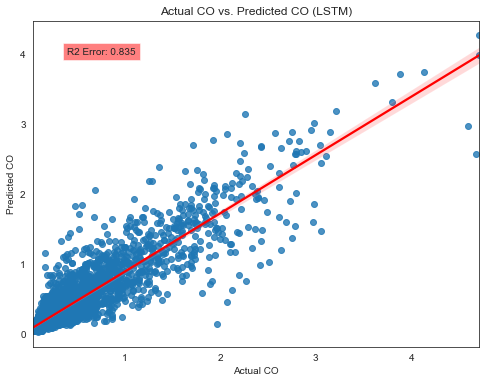

In [30]:
sns.set_style('white')

plt.figure(figsize = (8,6))
sns.regplot(inv_y, inv_yhat,line_kws = {'color': 'red'})
plt.title('Actual CO vs. Predicted CO (LSTM)')
plt.xlabel('Actual CO')
plt.ylabel('Predicted CO')
plt.text(0.4,4,"R2 Error: "+str(round(r2,3)),bbox=dict(facecolor='red', alpha=0.5))
plt.show()

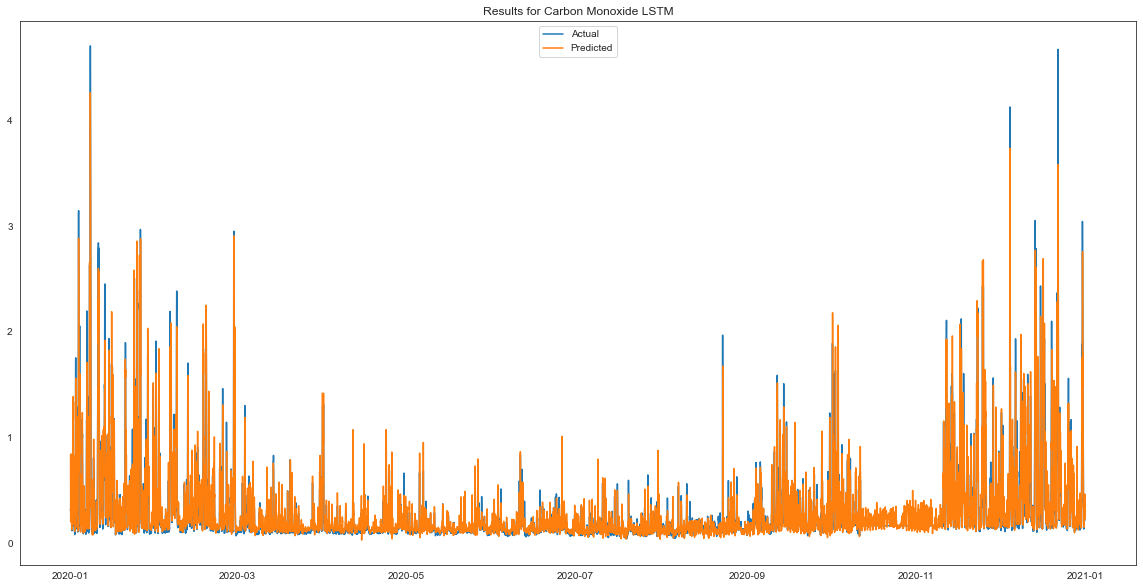

In [31]:
# plot expected vs actual
plt.figure(figsize=(20,10))
plt.plot(dates, inv_y, label='Actual')
plt.plot(dates, inv_yhat, label='Predicted')
plt.legend()
plt.title('Results for Carbon Monoxide LSTM')
plt.show()

#### CO -CNN

In [32]:
#Random code
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64,activity_regularizer=l1(0.001), kernel_size=2, activation='relu', input_shape=(5,9)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.2)) 
model_cnn.add(Flatten())
model_cnn.add(Dense(50,activity_regularizer=l1(0.001), activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='adam')
model_cnn.summary()

history_CNN=model_cnn.fit(CO_train_X, CO_train_y, epochs=100, batch_size=72, validation_data=(CO_valid_X, CO_valid_y), verbose=2,callbacks=[early_stopping], shuffle=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             1216      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 64)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 64)             0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 50)                6450      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                        

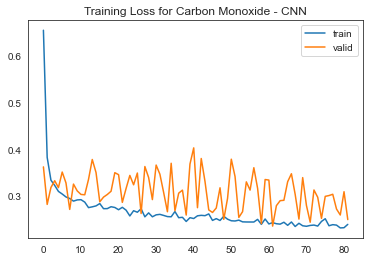

In [33]:
# plot history
plt.plot(history_CNN.history['loss'], label='train')
plt.plot(history_CNN.history['val_loss'], label='valid')
plt.legend()
plt.title('Training Loss for Carbon Monoxide - CNN')
plt.show()

In [34]:
yhat_CO_CNN=model_cnn.predict(CO_test_X)
yhat_CO_CNN = np.repeat(yhat_CO_CNN, 11, axis=-1)
inv_yhat_CO_CNN = scaler.inverse_transform(yhat_CO_CNN)[:,0]

In [35]:
# invert scaling for actual values
y_actual=CO_test_y.reshape(len(CO_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,0]

In [36]:
#Model Evaluation 100 epochs, standard scaler, dropout 0.2
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat_CO_CNN)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 0.175
Test MAE: 0.106
Test MAPE: 10.592
Test R2: 0.779


In [37]:
df_results=pd.DataFrame()
df_results['dates']=dates
df_results['Actual CO']=inv_y
df_results['Predicted CO']=inv_yhat_CO_CNN

df_results.tail(10)

,dates,Actual CO,Predicted CO
8774,2020-12-31 14:00:00,0.207,0.165563
8775,2020-12-31 15:00:00,0.184,0.175909
8776,2020-12-31 16:00:00,0.228,0.176368
8777,2020-12-31 17:00:00,0.299,0.231235
8778,2020-12-31 18:00:00,0.211,0.374129
8779,2020-12-31 19:00:00,0.283,0.291892
8780,2020-12-31 20:00:00,0.440,0.310354
8781,2020-12-31 21:00:00,0.298,0.583432
8782,2020-12-31 22:00:00,0.288,0.328419
8783,2020-12-31 23:00:00,0.297,0.230005


C:\Users\samik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


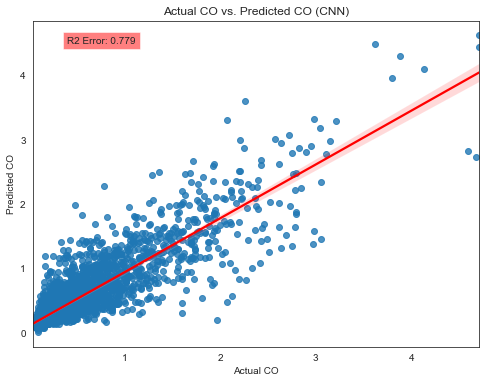

In [38]:
sns.set_style('white')

plt.figure(figsize = (8,6))
sns.regplot(inv_y, inv_yhat_CO_CNN,line_kws = {'color': 'red'})
plt.title('Actual CO vs. Predicted CO (CNN)')
plt.xlabel('Actual CO')
plt.ylabel('Predicted CO')
plt.text(0.4,4.5,"R2 Error: "+str(round(r2,3)),bbox=dict(facecolor='red', alpha=0.5))
plt.show()

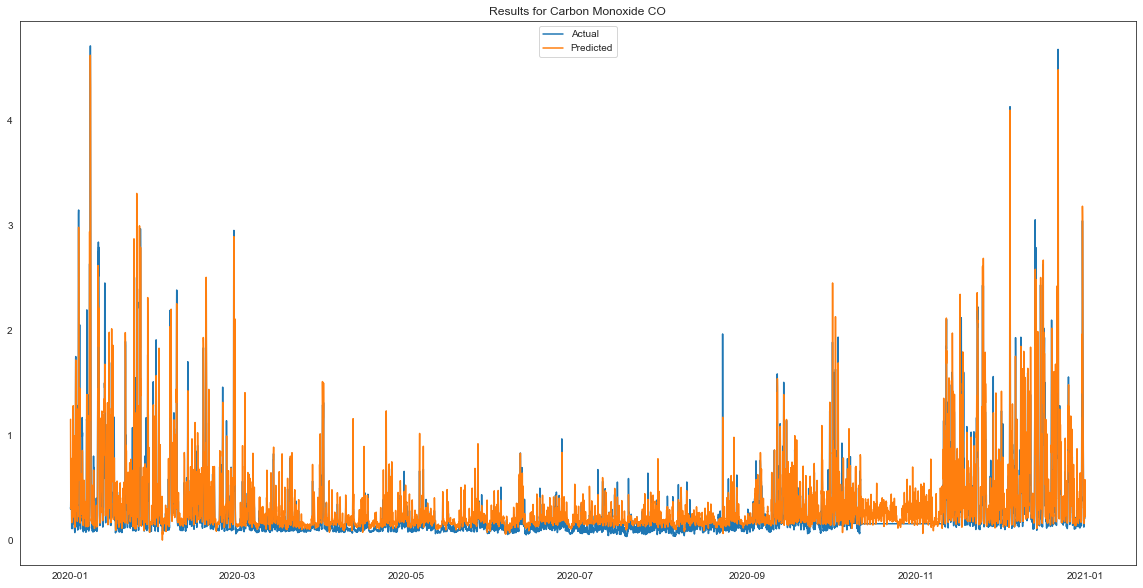

In [39]:
# plot expected vs actual
plt.figure(figsize=(20,10))
plt.plot(dates, inv_y, label='Actual')
plt.plot(dates, inv_yhat_CO_CNN, label='Predicted')
plt.legend()
plt.title('Results for Carbon Monoxide CO')
plt.show()

### CO -DFN

In [40]:
from keras.layers import Dropout
# import regularizer
from keras.regularizers import l1, l2
 
# instantiate regularizer
reg = l1(0.001)

#Random code
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

fdp=0.19+0.0025 * n_hours
model_CO_DBN = Sequential()
model_CO_DBN.add(Conv1D(filters=24, kernel_size=2, activation='relu',activity_regularizer=l2(0.001), input_shape=(CO_train_X.shape[1], CO_train_X.shape[2])))
model_CO_DBN.add(MaxPooling1D(pool_size=2))
model_CO_DBN.add(Dropout(0.2)) 
model_CO_DBN.add(LSTM(24,activation='relu'))
model_CO_DBN.add(Dense(50,  activation='relu',activity_regularizer=l2(0.001))) #50,
model_CO_DBN.add(Dropout(fdp))
model_CO_DBN.add(Dense(1))
model_CO_DBN.compile(optimizer='adam', loss='mse')

model_CO_DBN.summary()

# fit network
history = model_CO_DBN.fit(CO_train_X, CO_train_y, epochs=100, batch_size=72, validation_data=(CO_valid_X, CO_valid_y),callbacks=[early_stopping], verbose=2, shuffle=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 24)             456       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 24)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 24)             0         
                                                                 
 lstm (LSTM)                 (None, 24)                4704      
                                                                 
 dense (Dense)               (None, 50)                1250      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                        

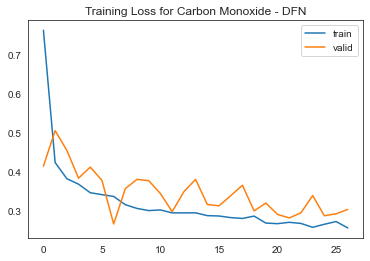

In [41]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.title('Training Loss for Carbon Monoxide - DFN')
plt.show()

In [42]:
model_CO_DBN.evaluate(CO_test_X,CO_test_y)

275/275 [==============================] - 0s 959us/step - loss: 0.2043


0.20433010160923004

In [43]:
yhat=model_CO_DBN.predict(CO_test_X)
yhat = np.repeat(yhat, 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,0]

In [44]:
# invert scaling for actual values
y_actual=CO_test_y.reshape(len(CO_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,0]

In [45]:
#Model Evaluation , change kernel size =2, with  fdp and 100 epochs, kernel size=2, dense=50, standard scaler, 0.2 dropout,l2 regularizer CNN + dense layer
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 0.187
Test MAE: 0.115
Test MAPE: 11.535
Test R2: 0.747


In [46]:
df_results=pd.DataFrame()
df_results['dates']=dates
df_results['Actual CO']=inv_y
df_results['Predicted CO']=inv_yhat

df_results.tail(10)

,dates,Actual CO,Predicted CO
8774,2020-12-31 14:00:00,0.207,0.163189
8775,2020-12-31 15:00:00,0.184,0.171955
8776,2020-12-31 16:00:00,0.228,0.186184
8777,2020-12-31 17:00:00,0.299,0.190816
8778,2020-12-31 18:00:00,0.211,0.378502
8779,2020-12-31 19:00:00,0.283,0.216955
8780,2020-12-31 20:00:00,0.440,0.282386
8781,2020-12-31 21:00:00,0.298,0.593229
8782,2020-12-31 22:00:00,0.288,0.300977
8783,2020-12-31 23:00:00,0.297,0.242104


C:\Users\samik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


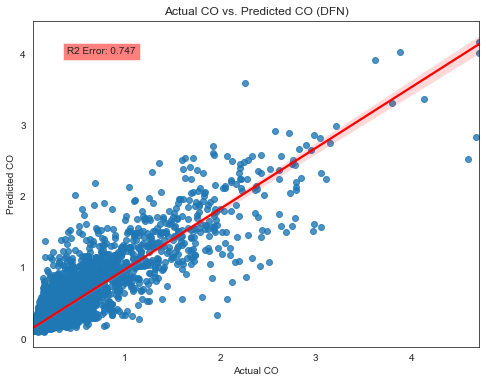

In [47]:
sns.set_style('white')

plt.figure(figsize = (8,6))
sns.regplot(inv_y, inv_yhat,line_kws = {'color': 'red'})
plt.title('Actual CO vs. Predicted CO (DFN)')
plt.xlabel('Actual CO')
plt.ylabel('Predicted CO')
plt.text(0.4,4,"R2 Error: "+str(round(r2,3)),bbox=dict(facecolor='red', alpha=0.5))
plt.show()

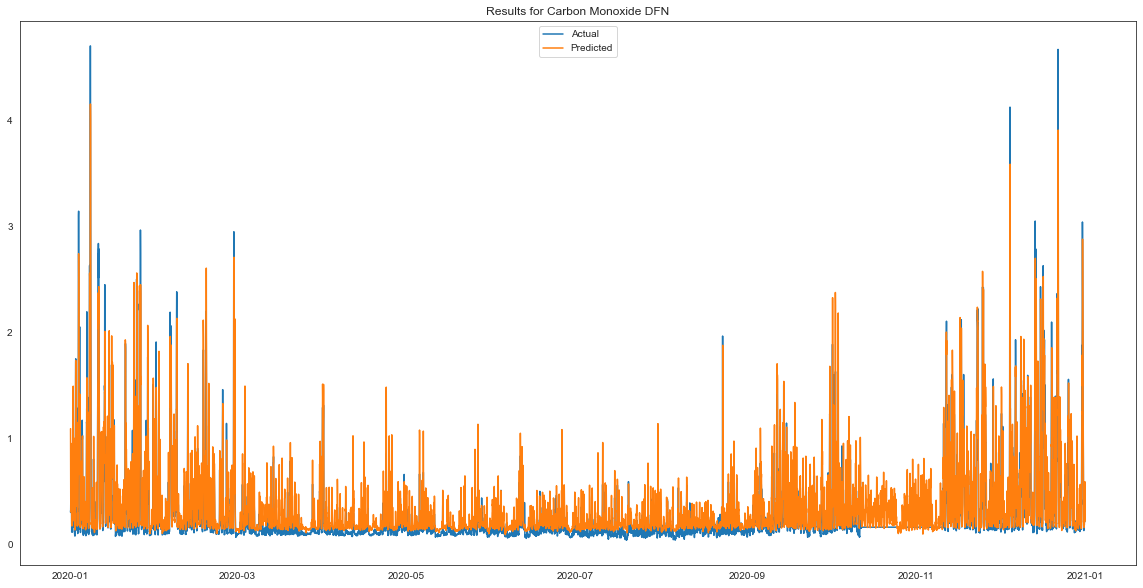

In [48]:
# plot expected vs actual
plt.figure(figsize=(20,10))
plt.plot(dates, inv_y, label='Actual')
plt.plot(dates, inv_yhat, label='Predicted')
plt.legend()
plt.title('Results for Carbon Monoxide DFN')
plt.show()

## Ozone Forecasting

In [49]:
df_OZONE=df.iloc[:,[2,0,1,8,9,10]] #0.920 r2 with 0.4 dropout best results
df_OZONE.head()

,OZONE,CO,NO2,Relative_Humidity,Temperature,Wind_Speed
2015-01-02 10:00:00,-0.182026,-0.482597,-0.599879,-0.359205,-1.371250,0.224861
2015-01-02 11:00:00,0.095772,-0.496857,-0.717961,-0.536764,-1.154079,-0.152468
2015-01-02 12:00:00,0.289706,-0.513493,-0.763377,-0.762775,-0.895541,-0.392585
2015-01-02 13:00:00,0.289706,-0.454077,-0.708877,-0.777822,-0.802467,-0.907124
2015-01-02 14:00:00,0.394536,-0.437441,-0.708877,-0.782035,-0.750760,-0.598401


In [50]:
# specify the number of lag hours
n_hours = 5
n_features = 6 #number of features in dataframe to be used

In [51]:
df_OZONE.head()

,OZONE,CO,NO2,Relative_Humidity,Temperature,Wind_Speed
2015-01-02 10:00:00,-0.182026,-0.482597,-0.599879,-0.359205,-1.371250,0.224861
2015-01-02 11:00:00,0.095772,-0.496857,-0.717961,-0.536764,-1.154079,-0.152468
2015-01-02 12:00:00,0.289706,-0.513493,-0.763377,-0.762775,-0.895541,-0.392585
2015-01-02 13:00:00,0.289706,-0.454077,-0.708877,-0.777822,-0.802467,-0.907124
2015-01-02 14:00:00,0.394536,-0.437441,-0.708877,-0.782035,-0.750760,-0.598401


In [52]:
# frame as supervised learning
scaled_Ozone=df_OZONE.values
reframed_Ozone = series_to_supervised(scaled_Ozone, n_hours, 1)
print(reframed_Ozone.shape)

(52569, 36)


In [53]:
#PM10:
Ozone_train_X, Ozone_train_y, Ozone_valid_X, Ozone_valid_y, Ozone_test_X, Ozone_test_y=split_data(reframed_Ozone,reshape='yes',n_hours=n_hours,n_features=n_features) #for lstm 3d data is required
print("training data Ozone:",Ozone_train_X.shape, len(Ozone_train_X), Ozone_train_y.shape,)
print("validation data Ozone:",Ozone_valid_X.shape, len(Ozone_valid_X), Ozone_test_X.shape)
print("testing data Ozone:",Ozone_test_X.shape, len(Ozone_test_X), Ozone_test_y.shape)

training data Ozone: (26265, 5, 6) 26265 (26265,)
validation data Ozone: (17520, 5, 6) 17520 (8784, 5, 6)
testing data Ozone: (8784, 5, 6) 8784 (8784,)


### Ozone - LSTM

In [54]:
#Random code
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

early_stopping = EarlyStopping(patience=20)

#model_Ozone=lstm_model(Ozone_train_X)

model_Ozone = Sequential()
model_Ozone.add(LSTM(50,input_shape=(Ozone_train_X.shape[1], Ozone_train_X.shape[2]))) #activity_regularizer=l2(0.001) not working well
model_Ozone.add(Dropout(0.4)) 
model_Ozone.add(Dense(1))
model_Ozone.compile(loss='mse', optimizer='adam')
model_Ozone.summary()

# fit network
history = model_Ozone.fit(Ozone_train_X, Ozone_train_y, epochs=100, batch_size=72, validation_data=(Ozone_valid_X, Ozone_valid_y), callbacks=[early_stopping, ModelCheckpoint(filepath='best_model_Ozone.h5', monitor='val_loss', save_best_only=True)],verbose=2, shuffle=False)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11,451
Trainable params: 11,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
365/365 - 3s - loss: 0.3352 - val_loss: 0.1704 - 3s/epoch - 8ms/step
Epoch 2/100
365/365 - 1s - loss: 0.1551 - val_loss: 0.1180 - 1s/epoch - 4ms/step
Epoch 3/100
365/365 - 1s - loss: 0.1239 - val_loss: 0.0976 - 1s/epoch - 3ms/step
Epoch 4/100
365/365 - 1s - loss: 0.1147 - val_loss: 0.0951 - 1s/epoch - 4

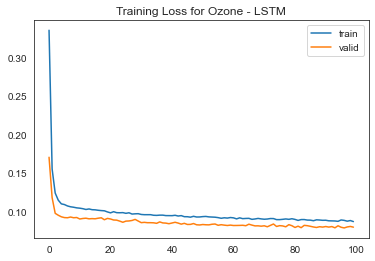

In [55]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.title('Training Loss for Ozone - LSTM')
plt.show()

In [56]:
model_Ozone.evaluate(Ozone_test_X, Ozone_test_y)

275/275 [==============================] - 0s 1ms/step - loss: 0.0800


0.07995455712080002

In [57]:
from keras.models import load_model
model_Ozone = load_model('best_model_Ozone.h5')
model_Ozone.evaluate(Ozone_test_X, Ozone_test_y)

275/275 [==============================] - 1s 1ms/step - loss: 0.0787


0.07873691618442535

In [58]:
yhat=model_Ozone.predict(Ozone_test_X)
yhat = np.repeat(yhat, 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,2]

In [59]:
# invert scaling for actual values
y_actual=Ozone_test_y.reshape(len(Ozone_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,2]

In [60]:
#Model Evaluation 100 epochs and 0.4 dropout with new features, new 2 features, best results, standard scaler, early stopping
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 0.005
Test MAE: 0.004
Test MAPE: 0.372
Test R2: 0.924


In [61]:
df_results=pd.DataFrame()
df_results['dates']=dates
df_results['Actual Ozone']=inv_y
df_results['Predicted Ozone']=inv_yhat

df_results.tail(10)

,dates,Actual Ozone,Predicted Ozone
8774,2020-12-31 14:00:00,0.0344,0.039436
8775,2020-12-31 15:00:00,0.0336,0.031243
8776,2020-12-31 16:00:00,0.0297,0.031326
8777,2020-12-31 17:00:00,0.0230,0.021870
8778,2020-12-31 18:00:00,0.0250,0.018733
8779,2020-12-31 19:00:00,0.0178,0.022100
8780,2020-12-31 20:00:00,0.0109,0.014286
8781,2020-12-31 21:00:00,0.0219,0.012593
8782,2020-12-31 22:00:00,0.0246,0.021084
8783,2020-12-31 23:00:00,0.0270,0.022421


C:\Users\samik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


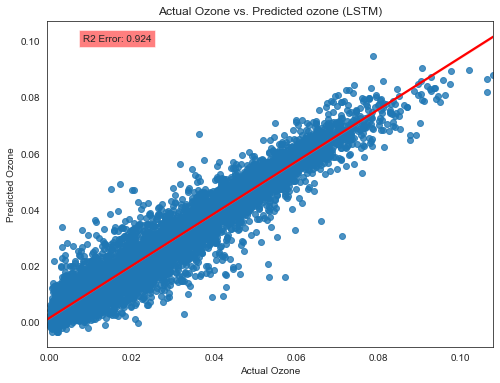

In [62]:
sns.set_style('white')

plt.figure(figsize = (8,6))
sns.regplot(inv_y, inv_yhat,line_kws = {'color': 'red'})
plt.title('Actual Ozone vs. Predicted ozone (LSTM)')
plt.xlabel('Actual Ozone')
plt.ylabel('Predicted Ozone')
plt.text(0.008,0.10,"R2 Error: "+str(round(r2,3)),bbox=dict(facecolor='red', alpha=0.5))
plt.show()

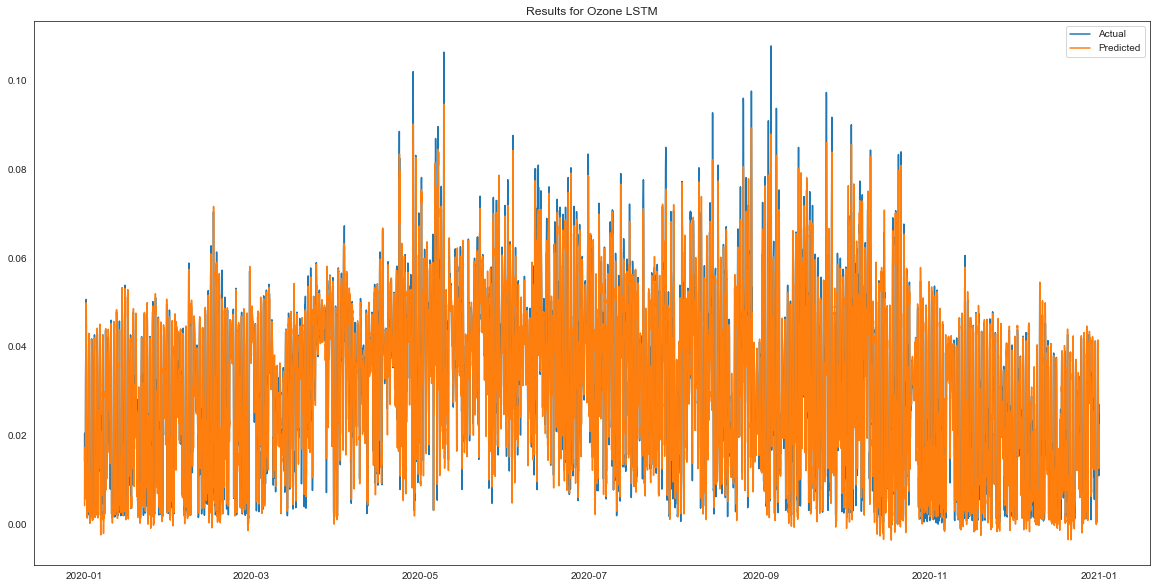

In [63]:
# plot expected vs actual
plt.figure(figsize=(20,10))
plt.plot(dates, inv_y, label='Actual')
plt.plot(dates, inv_yhat, label='Predicted')
plt.legend()
plt.title('Results for Ozone LSTM')
plt.show()

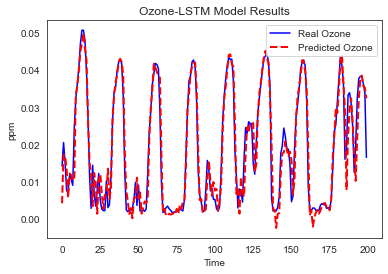

In [64]:
plt.plot(inv_y[:200], color = 'blue', label = 'Real Ozone')
plt.plot(inv_yhat[:200],"--", linewidth=2,color = 'red', label = 'Predicted Ozone')
plt.title('Ozone-LSTM Model Results')
plt.xlabel('Time')
plt.ylabel('ppm')
plt.legend()
plt.show()

In [65]:
#import aqi
#myaqi = aqi.to_iaqi(aqi.POLLUTANT_O3_8H, outcome_df['Predicted_Ozone'], algo=aqi.ALGO_EPA)

### Ozone- CNN

In [66]:
#model_Ozone_CNN=lstm_model(Ozone_train_X)
#Random code
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model_Ozone_CNN = Sequential()
model_Ozone_CNN.add(Conv1D(filters=24, kernel_size=2, activation='relu', input_shape=(Ozone_train_X.shape[1], Ozone_train_X.shape[2])))
model_Ozone_CNN.add(MaxPooling1D(pool_size=2))
model_Ozone_CNN.add(Flatten())
model_Ozone_CNN.add(Dense(50, activation='relu'))
model_Ozone_CNN.add(Dense(1))
model_Ozone_CNN.compile(optimizer='adam', loss='mse')

model_Ozone_CNN.summary()

# fit network
history = model_Ozone_CNN.fit(Ozone_train_X, Ozone_train_y, epochs=100, batch_size=72, validation_data=(Ozone_valid_X, Ozone_valid_y), verbose=2, shuffle=False)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 24)             312       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 24)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 50)                2450      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,813
Trainable params: 2,813
Non-trainable params: 0
______________________________________________________

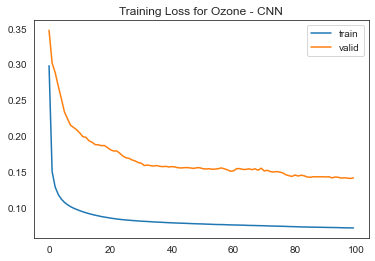

In [67]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Training Loss for Ozone - CNN')
plt.legend()
plt.show()

In [68]:
model_Ozone_CNN.evaluate(Ozone_test_X, Ozone_test_y)

275/275 [==============================] - 0s 675us/step - loss: 0.1489


0.14889967441558838

In [69]:
yhat=model_Ozone_CNN.predict(Ozone_test_X)
yhat = np.repeat(yhat, 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,2]

In [70]:
# invert scaling for actual values
y_actual=Ozone_test_y.reshape(len(Ozone_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,2]

In [71]:
#Model Evaluation , 100 epochs
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 0.007
Test MAE: 0.005
Test MAPE: 0.544
Test R2: 0.856


C:\Users\samik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


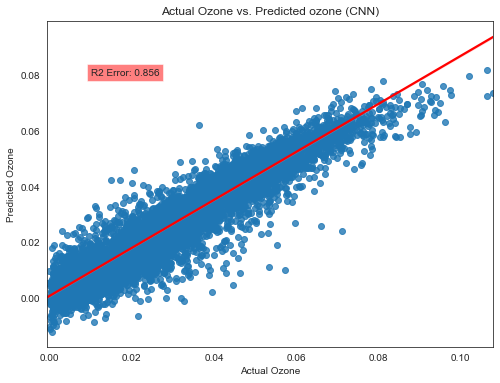

In [72]:
sns.set_style('white')

plt.figure(figsize = (8,6))
sns.regplot(inv_y, inv_yhat,line_kws = {'color': 'red'})
plt.title('Actual Ozone vs. Predicted ozone (CNN)')
plt.xlabel('Actual Ozone')
plt.ylabel('Predicted Ozone')
plt.text(0.01,0.08,"R2 Error: "+str(round(r2,3)),bbox=dict(facecolor='red', alpha=0.5))
plt.show()

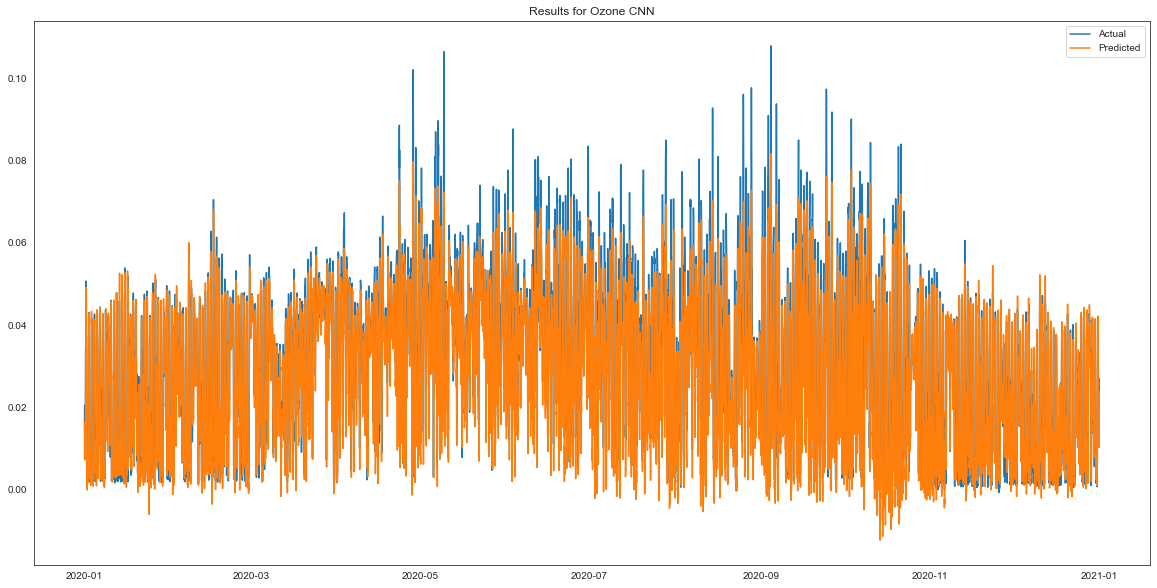

In [73]:
# plot expected vs actual
plt.figure(figsize=(20,10))
plt.plot(dates, inv_y, label='Actual')
plt.plot(dates, inv_yhat, label='Predicted')
plt.legend()
plt.title('Results for Ozone CNN')
plt.show()

### Ozone- DFN

In [74]:
#Random code
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

fdp=0.19+0.0025 * n_hours

model_Ozone_DBN = Sequential()
model_Ozone_DBN.add(Conv1D(filters=24, kernel_size=2, activation='relu', input_shape=(Ozone_train_X.shape[1], Ozone_train_X.shape[2])))
model_Ozone_DBN.add(MaxPooling1D(pool_size=2))
model_Ozone_DBN.add(Dropout(0.2))
model_Ozone_DBN.add(LSTM(24,activation='relu')) #24
#model_Ozone_DBN.add(Dropout(fdp))
model_Ozone_DBN.add(Flatten())
model_Ozone_DBN.add(Dense(50,activation='relu'))
model_Ozone_DBN.add(Dense(1))
model_Ozone_DBN.compile(optimizer='adam', loss='mse')

model_Ozone_DBN.summary()

# fit network
history = model_Ozone_DBN.fit(Ozone_train_X, Ozone_train_y, epochs=100, batch_size=72, validation_data=(Ozone_valid_X, Ozone_valid_y), verbose=2, shuffle=False)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 24)             312       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 24)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 24)             0         
                                                                 
 lstm (LSTM)                 (None, 24)                4704      
                                                                 
 flatten (Flatten)           (None, 24)                0         
                                                                 
 dense (Dense)               (None, 50)                1250      
                                                        

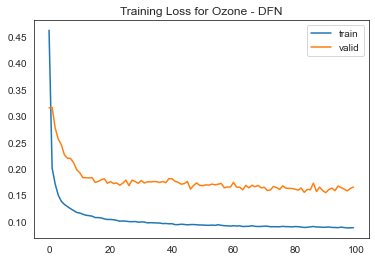

In [75]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Training Loss for Ozone - DFN')
plt.legend()
plt.show()

In [76]:
model_Ozone_DBN.evaluate(Ozone_test_X, Ozone_test_y)

275/275 [==============================] - 0s 926us/step - loss: 0.1669


0.16690349578857422

In [77]:
yhat=model_Ozone_DBN.predict(Ozone_test_X)
yhat = np.repeat(yhat, 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,2]

In [78]:
# invert scaling for actual values
y_actual=Ozone_test_y.reshape(len(Ozone_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,2]

In [79]:
#Model Evaluation - 100 epochs without fdp 24 LSTM
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 0.008
Test MAE: 0.006
Test MAPE: 0.594
Test R2: 0.839


C:\Users\samik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


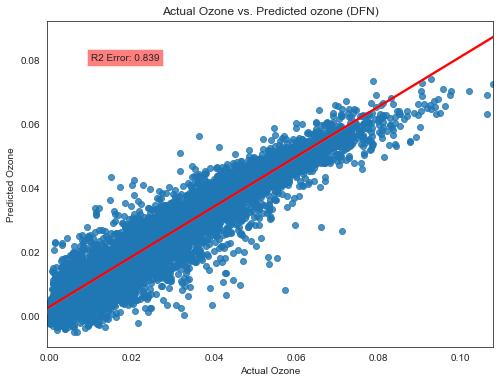

In [80]:
sns.set_style('white')

plt.figure(figsize = (8,6))
sns.regplot(inv_y, inv_yhat,line_kws = {'color': 'red'})
plt.title('Actual Ozone vs. Predicted ozone (DFN)')
plt.xlabel('Actual Ozone')
plt.ylabel('Predicted Ozone')
plt.text(0.01,0.08,"R2 Error: "+str(round(r2,3)),bbox=dict(facecolor='red', alpha=0.5))
plt.show()

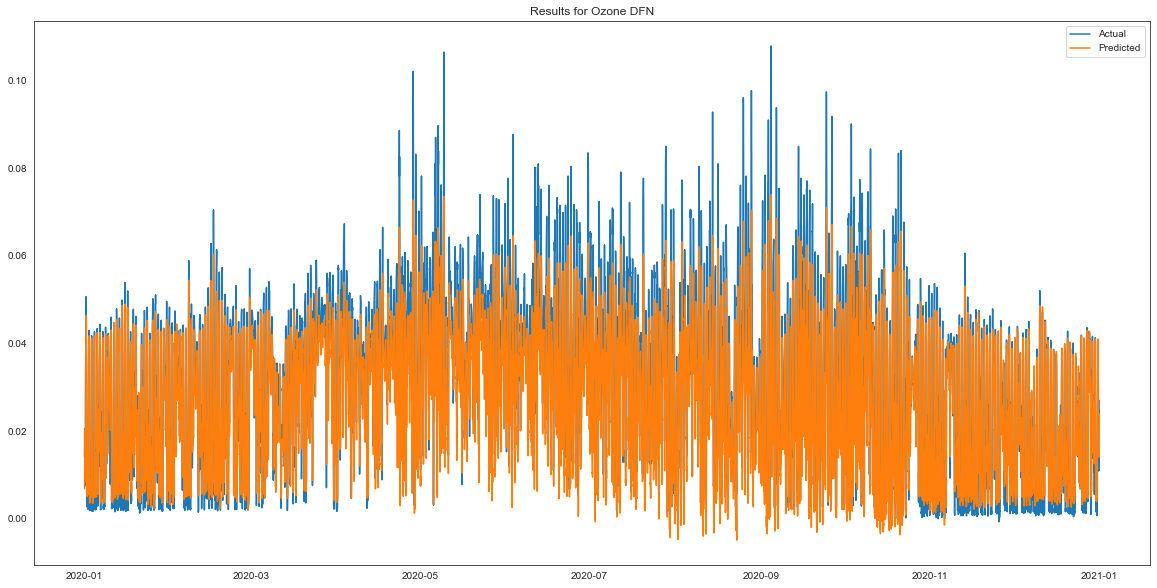

In [81]:
# plot expected vs actual
plt.figure(figsize=(20,10))
plt.plot(dates, inv_y, label='Actual')
plt.plot(dates, inv_yhat, label='Predicted')
plt.legend()
plt.title('Results for Ozone DFN')
plt.show()

## PM10 Forecasting

In [82]:
df_PM10=df.iloc[:,[3,0,1,2,4,5,10]] # continue with 7 features for all models

df_PM10.head()

,PM10,CO,NO2,OZONE,PM25,SO2,Wind_Speed
2015-01-02 10:00:00,-0.063857,-0.482597,-0.599879,-0.182026,-0.093282,0.005219,0.224861
2015-01-02 11:00:00,-0.155189,-0.496857,-0.717961,0.095772,-0.093282,-0.124040,-0.152468
2015-01-02 12:00:00,-0.312401,-0.513493,-0.763377,0.289706,0.166494,-0.253299,-0.392585
2015-01-02 13:00:00,-0.358815,-0.454077,-0.708877,0.289706,-0.014666,-0.382557,-0.907124
2015-01-02 14:00:00,-0.351329,-0.437441,-0.708877,0.394536,0.039597,-0.382557,-0.598401


In [83]:
# specify the number of lag hours
n_hours = 5
n_features =7 #number of features in dataframe to be used

In [84]:
# frame as supervised learning
scaled_PM10=df_PM10.values
reframed_PM10 = series_to_supervised(scaled_PM10, n_hours, 1)
print(reframed_PM10.shape)

(52569, 42)


In [87]:
#PM10:
PM10_train_X, PM10_train_y, PM10_test_X, PM10_test_y=split_ml(reframed_PM10,n_hours=n_hours,n_features=n_features) #for lstm 3d data is required

print("training data PM10:",PM10_train_X.shape, len(PM10_train_X), PM10_train_y.shape)
print("testing data PM10:",PM10_test_X.shape, len(PM10_test_X), PM10_test_y.shape)

training data PM10: (43785, 35) 43785 (43785,)
testing data PM10: (8784, 35) 8784 (8784,)


### PM10 Random Forest

In [90]:
#fit best model with 7 features, after bayes optimization

model_PM10 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=12, max_leaf_nodes=None,
                      max_samples=None,# min_impurity_decrease=0.0,
                     # min_impurity_split=None, 
                                   min_samples_leaf=11,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


model_PM10.fit(PM10_train_X, PM10_train_y)

C:\Users\samik\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


RandomForestRegressor(criterion='mse', max_depth=50, max_features=12,
                      min_samples_leaf=11, random_state=42)

In [91]:
yhat=model_PM10.predict(PM10_test_X)
yhat = np.repeat(yhat.reshape(-1,1), 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,3]

In [92]:
# invert scaling for actual values
y_actual=PM10_test_y.reshape(len(PM10_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,3]

In [93]:
#Model Evaluation,grid search random forest
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 37.865
Test MAE: 16.624
Test MAPE: 1662.378
Test R2: 0.545


In [253]:
#Model Evaluation,grid search random forest
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 37.754
Test MAE: 16.612
Test MAPE: 1661.155
Test R2: 0.548


In [94]:
df_results=pd.DataFrame()
df_results['dates']=dates
df_results['Actual PM10']=inv_y
df_results['Predicted PM10']=inv_yhat

df_results.tail(10)

,dates,Actual PM10,Predicted PM10
8774,2020-12-31 14:00:00,43.0,26.391943
8775,2020-12-31 15:00:00,42.1,44.996507
8776,2020-12-31 16:00:00,37.0,49.013029
8777,2020-12-31 17:00:00,58.2,42.630751
8778,2020-12-31 18:00:00,26.2,59.523315
8779,2020-12-31 19:00:00,46.8,27.710059
8780,2020-12-31 20:00:00,70.3,49.997434
8781,2020-12-31 21:00:00,39.4,74.339251
8782,2020-12-31 22:00:00,29.6,36.843899
8783,2020-12-31 23:00:00,40.0,29.338282


C:\Users\samik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


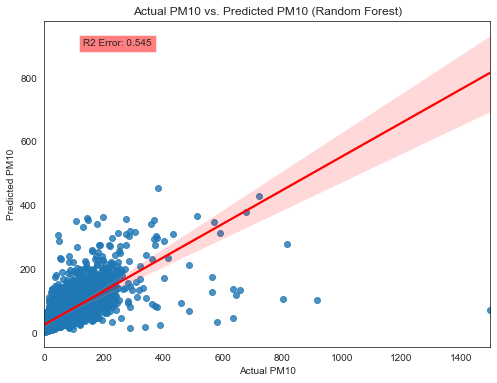

In [95]:
sns.set_style('white')

plt.figure(figsize = (8,6))
sns.regplot(inv_y, inv_yhat,line_kws = {'color': 'red'})
plt.title('Actual PM10 vs. Predicted PM10 (Random Forest)')
plt.xlabel('Actual PM10')
plt.ylabel('Predicted PM10')
plt.text(130,900,"R2 Error: "+str(round(r2,3)),bbox=dict(facecolor='red', alpha=0.5))
plt.show()

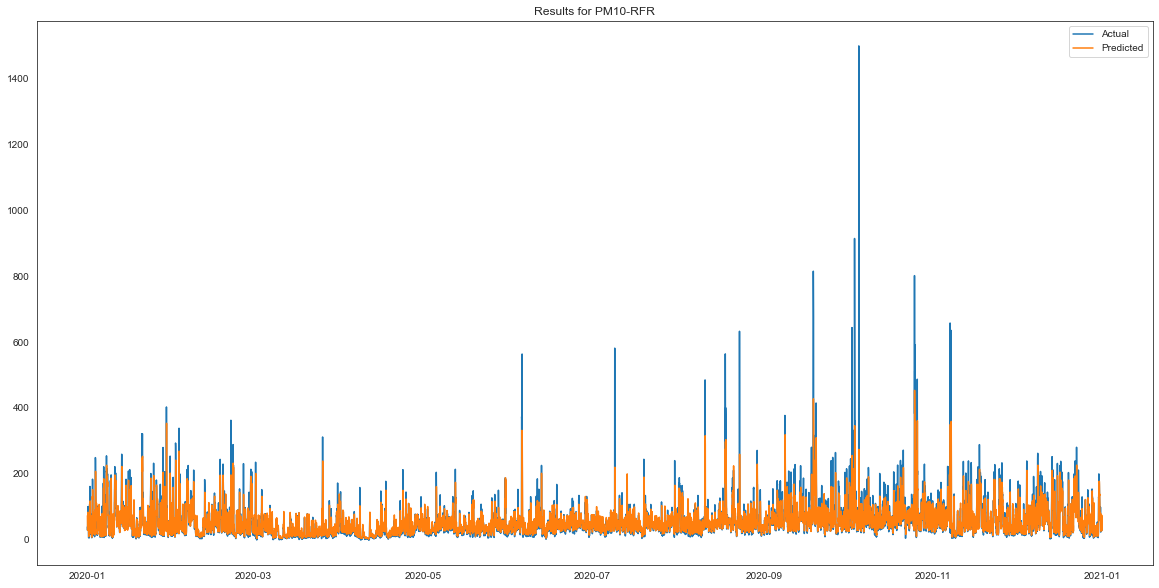

In [96]:
# plot expected vs actual
plt.figure(figsize=(20,10))
plt.plot(dates, inv_y, label='Actual')
plt.plot(dates, inv_yhat, label='Predicted')
plt.legend()
plt.title('Results for PM10-RFR')
plt.show()

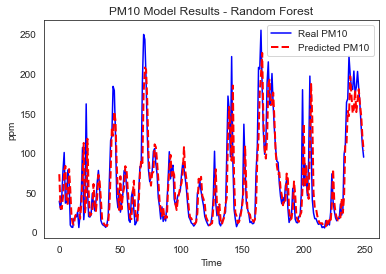

In [97]:
plt.plot(inv_y[:250], color = 'blue', label = 'Real PM10')
plt.plot(inv_yhat[:250],"--", linewidth=2,color = 'red', label = 'Predicted PM10')
plt.title('PM10 Model Results - Random Forest')
plt.xlabel('Time')
plt.ylabel('ppm')
plt.legend()
plt.show()

### PM10 GBR

In [98]:
gbr = GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.1, loss = "huber", 
                                random_state = 42, n_iter_no_change = 20)

gbr.fit(PM10_train_X, PM10_train_y)

GradientBoostingRegressor(loss='huber', n_estimators=200, n_iter_no_change=20,
                          random_state=42)

In [99]:
yhat=gbr.predict(PM10_test_X)
yhat = np.repeat(yhat.reshape(-1,1), 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,3]

In [100]:
# invert scaling for actual values
y_actual=PM10_test_y.reshape(len(PM10_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,3]

In [101]:
#Model Evaluation,
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 38.423
Test MAE: 16.472
Test MAPE: 1647.150
Test R2: 0.531


In [261]:
#Model Evaluation,
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 38.329
Test MAE: 16.421
Test MAPE: 1642.148
Test R2: 0.534


In [102]:
df_results=pd.DataFrame()
df_results['dates']=dates
df_results['Actual PM10']=inv_y
df_results['Predicted PM10']=inv_yhat

df_results.tail(10)

,dates,Actual PM10,Predicted PM10
8774,2020-12-31 14:00:00,43.0,25.702069
8775,2020-12-31 15:00:00,42.1,44.133783
8776,2020-12-31 16:00:00,37.0,45.219194
8777,2020-12-31 17:00:00,58.2,41.110901
8778,2020-12-31 18:00:00,26.2,55.953809
8779,2020-12-31 19:00:00,46.8,26.215243
8780,2020-12-31 20:00:00,70.3,45.211739
8781,2020-12-31 21:00:00,39.4,65.419625
8782,2020-12-31 22:00:00,29.6,38.254612
8783,2020-12-31 23:00:00,40.0,28.663032


C:\Users\samik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


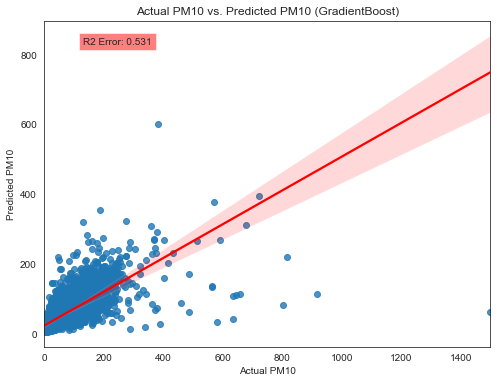

In [103]:
sns.set_style('white')

plt.figure(figsize = (8,6))
sns.regplot(inv_y, inv_yhat,line_kws = {'color': 'red'})
plt.title('Actual PM10 vs. Predicted PM10 (GradientBoost)')
plt.xlabel('Actual PM10')
plt.ylabel('Predicted PM10')
plt.text(130,830,"R2 Error: "+str(round(r2,3)),bbox=dict(facecolor='red', alpha=0.5))
plt.show()

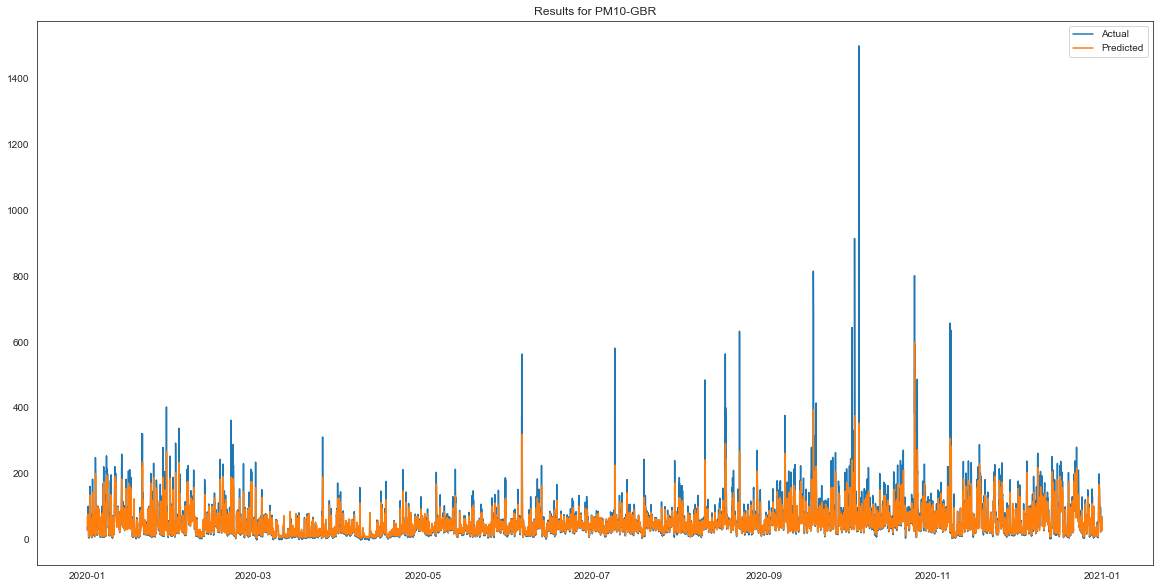

In [104]:
# plot expected vs actual
plt.figure(figsize=(20,10))
plt.plot(dates, inv_y, label='Actual')
plt.plot(dates, inv_yhat, label='Predicted')
plt.legend()
plt.title('Results for PM10-GBR')
plt.show()

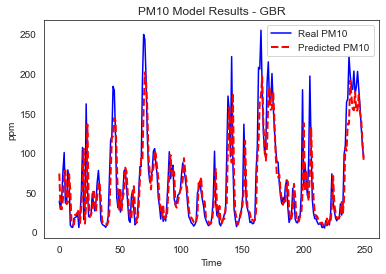

In [105]:
plt.plot(inv_y[:250], color = 'blue', label = 'Real PM10')
plt.plot(inv_yhat[:250],"--", linewidth=2,color = 'red', label = 'Predicted PM10')
plt.title('PM10 Model Results - GBR')
plt.xlabel('Time')
plt.ylabel('ppm')
plt.legend()
plt.show()

### Ensemble Model

In [106]:
r1=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=12, max_leaf_nodes=None,
                      max_samples=None, #min_impurity_decrease=0.0,
                      #min_impurity_split=None,
                         min_samples_leaf=11,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

r2=GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.1, loss = "huber", 
                                random_state = 42, n_iter_no_change = 20)


vr_PM10 = VotingRegressor([('rf', r1), ('gb', r2)],weights =[3,1])

vr_PM10.fit(PM10_train_X, PM10_train_y)

C:\Users\samik\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(criterion='mse',
                                                   max_depth=50,
                                                   max_features=12,
                                                   min_samples_leaf=11,
                                                   random_state=42)),
                            ('gb',
                             GradientBoostingRegressor(loss='huber',
                                                       n_estimators=200,
                                                       n_iter_no_change=20,
                                                       random_state=42))],
                weights=[3, 1])

In [107]:
yhat=vr_PM10.predict(PM10_test_X)
yhat = np.repeat(yhat.reshape(-1,1), 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,3]

# invert scaling for actual values
y_actual=PM10_test_y.reshape(len(PM10_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,3]

#Model Evaluation, stacking, weights two, 3 1
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 37.830
Test MAE: 16.460
Test MAPE: 1646.022
Test R2: 0.546


In [108]:
df_results=pd.DataFrame()
df_results['dates']=dates
df_results['Actual PM10']=inv_y
df_results['Predicted PM10']=inv_yhat

df_results.tail(10)

,dates,Actual PM10,Predicted PM10
8774,2020-12-31 14:00:00,43.0,26.219474
8775,2020-12-31 15:00:00,42.1,44.780826
8776,2020-12-31 16:00:00,37.0,48.064570
8777,2020-12-31 17:00:00,58.2,42.250789
8778,2020-12-31 18:00:00,26.2,58.630939
8779,2020-12-31 19:00:00,46.8,27.336355
8780,2020-12-31 20:00:00,70.3,48.801010
8781,2020-12-31 21:00:00,39.4,72.109345
8782,2020-12-31 22:00:00,29.6,37.196577
8783,2020-12-31 23:00:00,40.0,29.169469


C:\Users\samik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


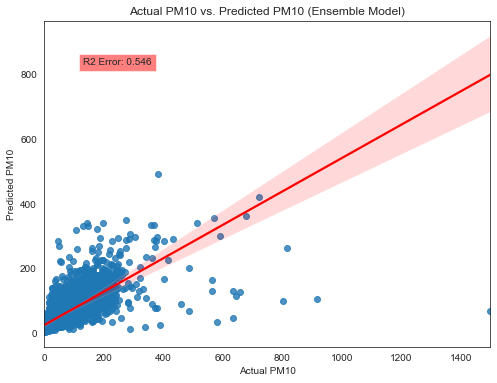

In [109]:
sns.set_style('white')

plt.figure(figsize = (8,6))
sns.regplot(inv_y, inv_yhat,line_kws = {'color': 'red'})
plt.title('Actual PM10 vs. Predicted PM10 (Ensemble Model)')
plt.xlabel('Actual PM10')
plt.ylabel('Predicted PM10')
plt.text(130,830,"R2 Error: "+str(round(r2,3)),bbox=dict(facecolor='red', alpha=0.5))
plt.show()

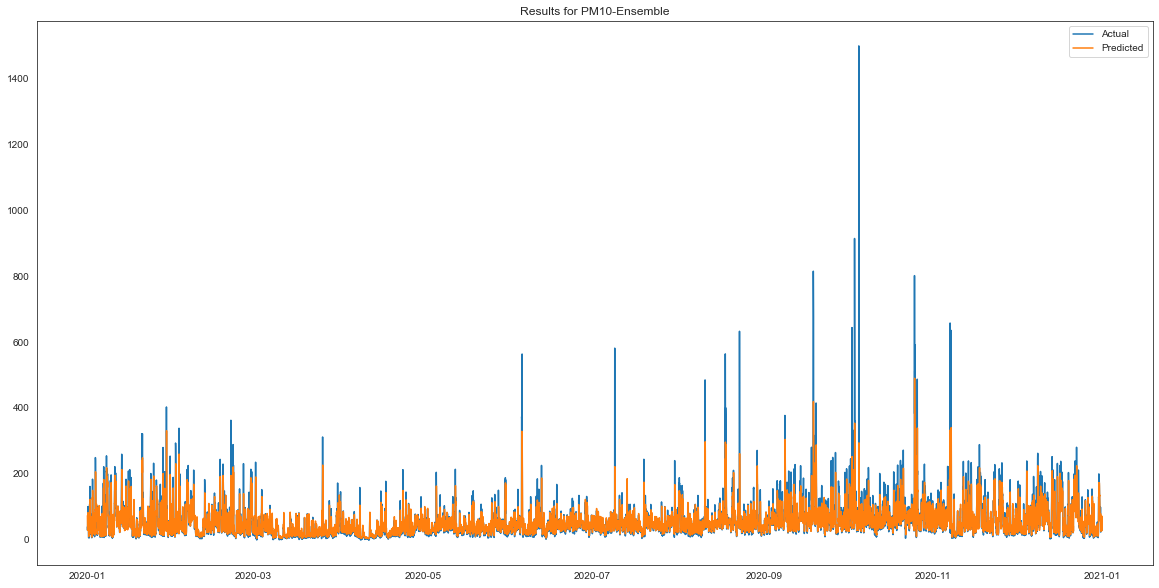

In [110]:
# plot expected vs actual
plt.figure(figsize=(20,10))
plt.plot(dates, inv_y, label='Actual')
plt.plot(dates, inv_yhat, label='Predicted')
plt.legend()
plt.title('Results for PM10-Ensemble')
plt.show()

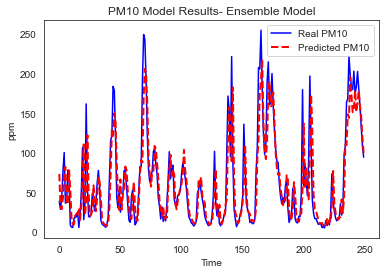

In [111]:
plt.plot(inv_y[:250], color = 'blue', label = 'Real PM10')
plt.plot(inv_yhat[:250],"--", linewidth=2,color = 'red', label = 'Predicted PM10')
plt.title('PM10 Model Results- Ensemble Model')
plt.xlabel('Time')
plt.ylabel('ppm')
plt.legend()
plt.show()

In [112]:
Pkl_Filename = "best_model_PM10.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(vr_PM10, file)

## PM2.5 Forecasting

In [113]:
df_PM25=df.iloc[:,[4,3,6,7,8,9,10]] #CNN 0.455, better
#df_PM25=df.iloc[:,[4,3,6,8,10]] Try with this once
df_PM25.head()

,PM25,PM10,Barometric_Pressure,Dewpoint,Relative_Humidity,Temperature,Wind_Speed
2015-01-02 10:00:00,-0.093282,-0.063857,1.331716,-0.390781,-0.359205,-1.371250,0.224861
2015-01-02 11:00:00,-0.093282,-0.155189,1.143620,-0.524329,-0.536764,-1.154079,-0.152468
2015-01-02 12:00:00,0.166494,-0.312401,0.977468,-1.337763,-0.762775,-0.895541,-0.392585
2015-01-02 13:00:00,-0.014666,-0.358815,0.914769,-1.532016,-0.777822,-0.802467,-0.907124
2015-01-02 14:00:00,0.039597,-0.351329,0.852070,-1.871958,-0.782035,-0.750760,-0.598401


In [114]:
# specify the number of lag hours
n_hours = 5
n_features = 7 #number of features in dataframe to be used

In [115]:
# frame as supervised learning
scaled_PM25=df_PM25.values
reframed_PM25 = series_to_supervised(scaled_PM25, n_hours, 1)
print(reframed_PM25.shape)

(52569, 42)


In [116]:
#PM25:
PM25_train_X, PM25_train_y, PM25_test_X, PM25_test_y=split_ml(reframed_PM25,n_hours=n_hours,n_features=n_features) #for lstm 3d data is required

print("training data CO:",PM25_train_X.shape, len(PM25_train_X), PM25_train_y.shape)
print("testing data CO:",PM25_test_X.shape, len(PM25_test_X), PM25_test_y.shape)

training data CO: (43785, 35) 43785 (43785,)
testing data CO: (8784, 35) 8784 (8784,)


### PM2.5 Random Forest

In [118]:
model_PM25_rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=11, max_leaf_nodes=None,
                      max_samples=None, #min_impurity_decrease=0.0,
                      #min_impurity_split=None,
                                      min_samples_leaf=1,
                      min_samples_split=11, min_weight_fraction_leaf=0.0,
                      n_estimators=53, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

model_PM25_rf.fit(PM25_train_X, PM25_train_y)

C:\Users\samik\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


RandomForestRegressor(criterion='mse', max_depth=50, max_features=11,
                      min_samples_split=11, n_estimators=53, random_state=42)

In [119]:
yhat=model_PM25_rf.predict(PM25_test_X)
yhat = np.repeat(yhat.reshape(-1,1), 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,4]

# invert scaling for actual values
y_actual=PM25_test_y.reshape(len(PM25_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,4]

#Model Evaluation - 8 new set
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 4.690
Test MAE: 2.817
Test MAPE: 281.670
Test R2: 0.428


In [120]:
df_results=pd.DataFrame()
df_results['dates']=dates
df_results['Actual PM25']=inv_y
df_results['Predicted PM25']=inv_yhat

df_results.tail(10)

,dates,Actual PM25,Predicted PM25
8774,2020-12-31 14:00:00,6.0,4.408071
8775,2020-12-31 15:00:00,4.0,4.374832
8776,2020-12-31 16:00:00,2.0,2.576597
8777,2020-12-31 17:00:00,2.0,2.144483
8778,2020-12-31 18:00:00,3.0,3.358249
8779,2020-12-31 19:00:00,10.0,2.657517
8780,2020-12-31 20:00:00,28.0,5.003565
8781,2020-12-31 21:00:00,2.0,12.712062
8782,2020-12-31 22:00:00,2.0,2.750279
8783,2020-12-31 23:00:00,5.0,4.598411


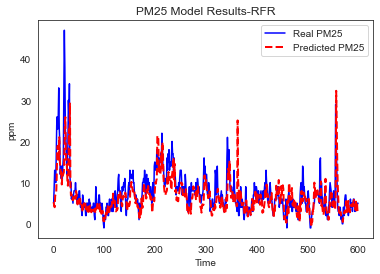

In [121]:
plt.plot(inv_y[900:1500], color = 'blue', label = 'Real PM25')
plt.plot(inv_yhat[900:1500],"--", linewidth=2,color = 'red', label = 'Predicted PM25')
plt.title('PM25 Model Results-RFR')
plt.xlabel('Time')
plt.ylabel('ppm')
plt.legend()
plt.show()

C:\Users\samik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


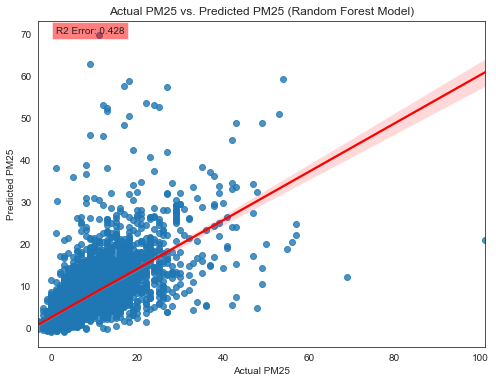

In [122]:
sns.set_style('white')

plt.figure(figsize = (8,6))
sns.regplot(inv_y, inv_yhat,line_kws = {'color': 'red'})
plt.title('Actual PM25 vs. Predicted PM25 (Random Forest Model)')
plt.xlabel('Actual PM25')
plt.ylabel('Predicted PM25')
plt.text(1,70,"R2 Error: "+str(round(r2,3)),bbox=dict(facecolor='red', alpha=0.5))
plt.show()

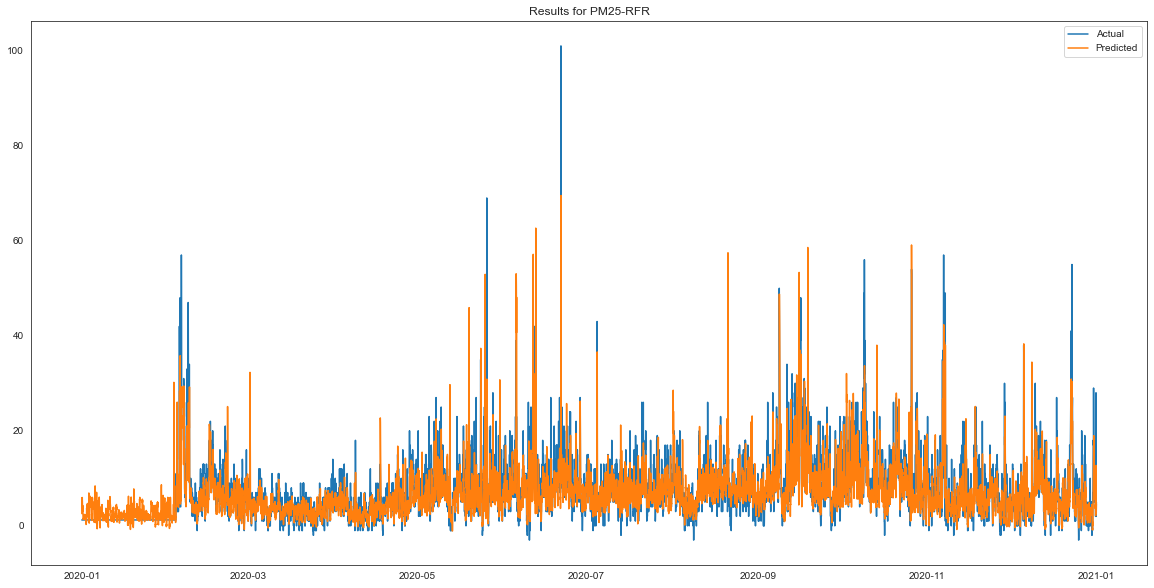

In [123]:
# plot expected vs actual
plt.figure(figsize=(20,10))
plt.plot(dates, inv_y, label='Actual')
plt.plot(dates, inv_yhat, label='Predicted')
plt.legend()
plt.title('Results for PM25-RFR')
plt.show()

### PM2.5 GBR

In [124]:
gbr = GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.1, loss = "huber", 
                                random_state = 42, n_iter_no_change = 20)

gbr.fit(PM25_train_X, PM25_train_y)

GradientBoostingRegressor(loss='huber', n_estimators=200, n_iter_no_change=20,
                          random_state=42)

In [125]:
yhat=gbr.predict(PM25_test_X)
yhat = np.repeat(yhat.reshape(-1,1), 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,4]

# invert scaling for actual values
y_actual=PM25_test_y.reshape(len(PM25_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,4]

#Model Evaluation - 8 new set
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 4.231
Test MAE: 2.498
Test MAPE: 249.849
Test R2: 0.535


In [126]:
df_results=pd.DataFrame()
df_results['dates']=dates
df_results['Actual PM25']=inv_y
df_results['Predicted PM25']=inv_yhat

df_results.tail(10)

,dates,Actual PM25,Predicted PM25
8774,2020-12-31 14:00:00,6.0,4.794391
8775,2020-12-31 15:00:00,4.0,5.029477
8776,2020-12-31 16:00:00,2.0,4.437151
8777,2020-12-31 17:00:00,2.0,3.407847
8778,2020-12-31 18:00:00,3.0,3.042937
8779,2020-12-31 19:00:00,10.0,2.536477
8780,2020-12-31 20:00:00,28.0,4.943305
8781,2020-12-31 21:00:00,2.0,16.201902
8782,2020-12-31 22:00:00,2.0,4.425977
8783,2020-12-31 23:00:00,5.0,3.266896


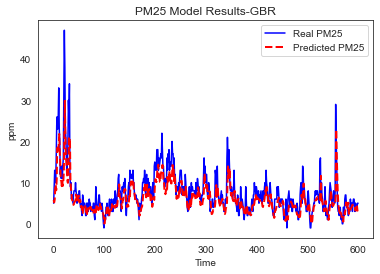

In [127]:
plt.plot(inv_y[900:1500], color = 'blue', label = 'Real PM25')
plt.plot(inv_yhat[900:1500],"--", linewidth=2,color = 'red', label = 'Predicted PM25')
plt.title('PM25 Model Results-GBR')
plt.xlabel('Time')
plt.ylabel('ppm')
plt.legend()
plt.show()

C:\Users\samik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


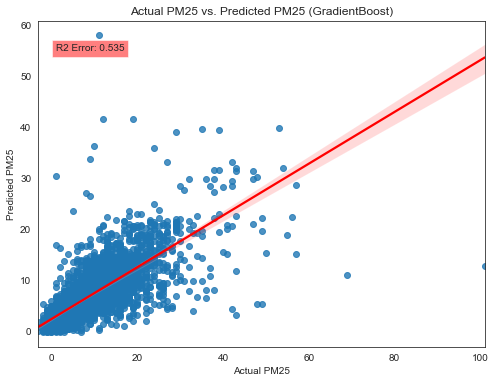

In [128]:
sns.set_style('white')

plt.figure(figsize = (8,6))
sns.regplot(inv_y, inv_yhat,line_kws = {'color': 'red'})
plt.title('Actual PM25 vs. Predicted PM25 (GradientBoost)')
plt.xlabel('Actual PM25')
plt.ylabel('Predicted PM25')
plt.text(1,55,"R2 Error: "+str(round(r2,3)),bbox=dict(facecolor='red', alpha=0.5))
plt.show()

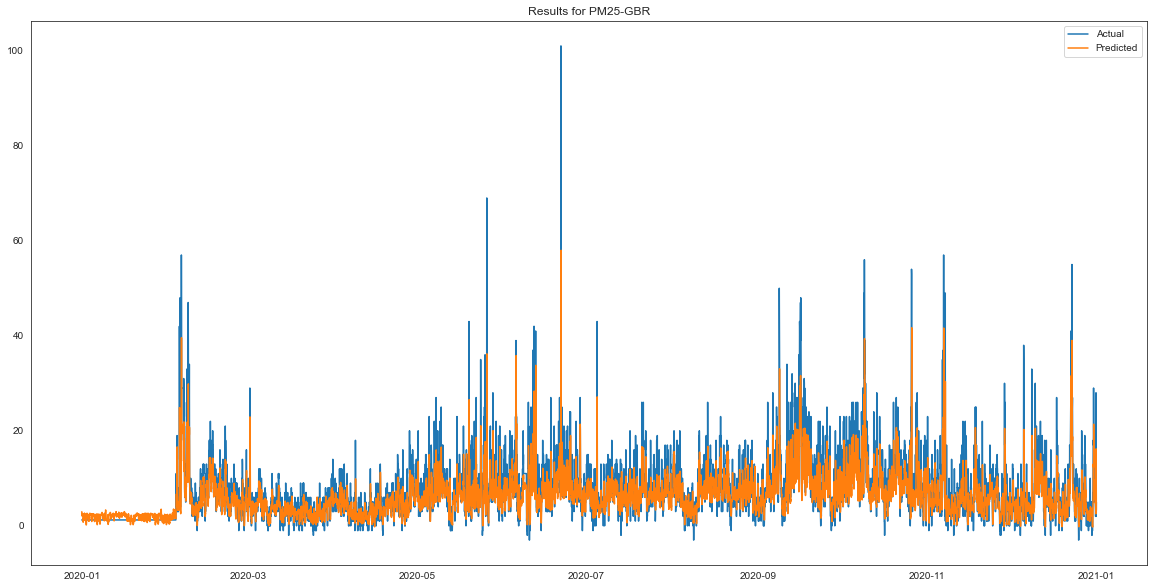

In [129]:
# plot expected vs actual
plt.figure(figsize=(20,10))
plt.plot(dates, inv_y, label='Actual')
plt.plot(dates, inv_yhat, label='Predicted')
plt.legend()
plt.title('Results for PM25-GBR')
plt.show()

### PM2.5 Ensemble

In [130]:
r1=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=11, max_leaf_nodes=None,
                      max_samples=None,# min_impurity_decrease=0.0,
                      #min_impurity_split=None,
                         min_samples_leaf=1,
                      min_samples_split=11, min_weight_fraction_leaf=0.0,
                      n_estimators=53, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

r2=GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.1, loss = "huber", 
                                random_state = 42, n_iter_no_change = 20)


vr = VotingRegressor([('rf', r1), ('gb', r2)],weights =[1,6]) #6 best

vr.fit(PM25_train_X, PM25_train_y)

C:\Users\samik\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(criterion='mse',
                                                   max_depth=50,
                                                   max_features=11,
                                                   min_samples_split=11,
                                                   n_estimators=53,
                                                   random_state=42)),
                            ('gb',
                             GradientBoostingRegressor(loss='huber',
                                                       n_estimators=200,
                                                       n_iter_no_change=20,
                                                       random_state=42))],
                weights=[1, 6])

In [131]:
yhat=vr.predict(PM25_test_X)
yhat = np.repeat(yhat.reshape(-1,1), 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,4]

# invert scaling for actual values
y_actual=PM25_test_y.reshape(len(PM25_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,4]

#Model Evaluation - 8 new set
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 4.210
Test MAE: 2.495
Test MAPE: 249.507
Test R2: 0.539


In [132]:
df_results=pd.DataFrame()
df_results['dates']=dates
df_results['Actual PM25']=inv_y
df_results['Predicted PM25']=inv_yhat

df_results.tail(10)

,dates,Actual PM25,Predicted PM25
8774,2020-12-31 14:00:00,6.0,4.739203
8775,2020-12-31 15:00:00,4.0,4.935957
8776,2020-12-31 16:00:00,2.0,4.171358
8777,2020-12-31 17:00:00,2.0,3.227366
8778,2020-12-31 18:00:00,3.0,3.087982
8779,2020-12-31 19:00:00,10.0,2.553768
8780,2020-12-31 20:00:00,28.0,4.951914
8781,2020-12-31 21:00:00,2.0,15.703354
8782,2020-12-31 22:00:00,2.0,4.186591
8783,2020-12-31 23:00:00,5.0,3.457112


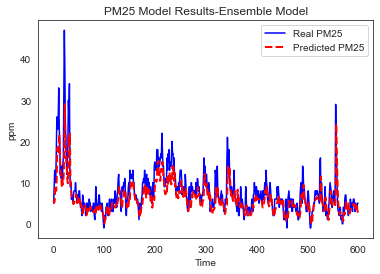

In [133]:
plt.plot(inv_y[900:1500], color = 'blue', label = 'Real PM25')
plt.plot(inv_yhat[900:1500],"--", linewidth=2,color = 'red', label = 'Predicted PM25')
plt.title('PM25 Model Results-Ensemble Model')
plt.xlabel('Time')
plt.ylabel('ppm')
plt.legend()
plt.show()

C:\Users\samik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


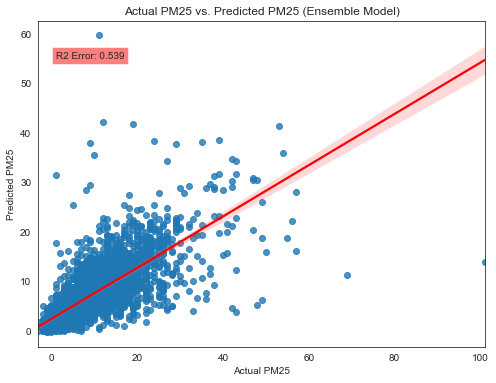

In [134]:
sns.set_style('white')

plt.figure(figsize = (8,6))
sns.regplot(inv_y, inv_yhat,line_kws = {'color': 'red'})
plt.title('Actual PM25 vs. Predicted PM25 (Ensemble Model)')
plt.xlabel('Actual PM25')
plt.ylabel('Predicted PM25')
plt.text(1,55,"R2 Error: "+str(round(r2,3)),bbox=dict(facecolor='red', alpha=0.5))
plt.show()

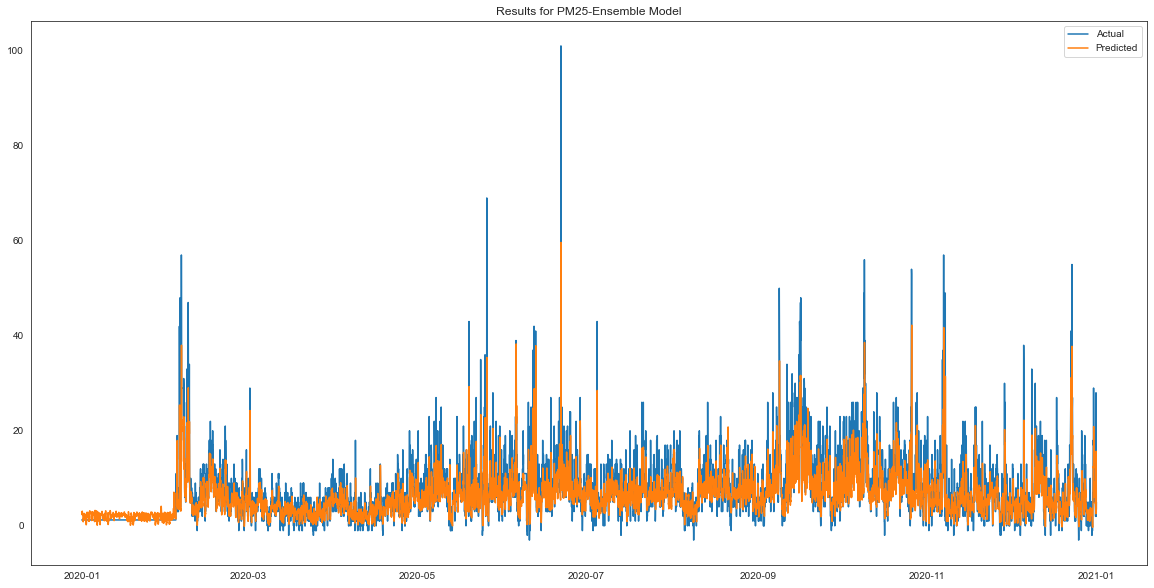

In [135]:
# plot expected vs actual
plt.figure(figsize=(20,10))
plt.plot(dates, inv_y, label='Actual')
plt.plot(dates, inv_yhat, label='Predicted')
plt.legend()
plt.title('Results for PM25-Ensemble Model')
plt.show()

In [136]:
Pkl_Filename = "best_model_PM25.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(vr, file)